<a href="https://colab.research.google.com/github/Almogbs/Intro-to-ML-HW2-Algo-Implementation/blob/main/ML_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Machine Learning - HW2

>[Introduction to Machine Learning - HW2](#scrollTo=fFRzJTKmm3MS)

>[Preliminary: Data Loading:](#scrollTo=OqAvhJUVSpNV)

>[Part 1: Basic model selection with k-Nearest Neighbors](#scrollTo=ztSK9epvUiNI)

>>[Visualization and basic analysis](#scrollTo=OEJtOFEoY_Bz)

>>>>[Q1:  jointplot of PCR_01, PCR_02:](#scrollTo=CQ9XknQtZR8h)

>>>>[Q2:  kNN (k=1) PCR_01, PCR_02:](#scrollTo=o5E1cNl4ZH21)

>>[Model selection](#scrollTo=woLtsF4haVlf)

>>>>[Q3:  Finding the optimal K for our problem (hyperparameter tuning):](#scrollTo=Cn5QOED_abRR)

>>>>[Q4:  Using the optimal K we found:](#scrollTo=Y5n913Leld-_)

>>>>[Q5:  kNN with k=1, k=501:](#scrollTo=kSKstYFsoZj0)

>>>>[Q6:  kNN with all of the features:](#scrollTo=_CTDujZYpLPC)

>[Part 2: Decision trees](#scrollTo=Zc5HAGVryHtX)

>>[Visualization](#scrollTo=3TIhXCWayRFi)

>>>>[Q7:  DT with all max depth of 4:](#scrollTo=IWjgjxqByV0T)

>>[Model selection](#scrollTo=VFEtzwQp15dE)

>>>>[Q8:  DT hyperparameters (max_depth, min_samples_leaf):](#scrollTo=EiyEmkgg2kdG)

>>>>[Q9:  DT with the optimal hyperparameters:](#scrollTo=I7Dj1ObzMqG4)

>[Part 3: Linear SVM and the Polynomial kernel](#scrollTo=yGPPyjYZNeHC)

>>[Implementation of the loss and its gradient](#scrollTo=Wu-T3vUMOOCn)

>>[Using a feature mapping](#scrollTo=sgHU_6KSIW3H)



# Preliminary: Data Loading:

a. Loading the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from google.colab.data_table import DataTable

DataTable.max_columns = 40
!rm *.csv

print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

dataset = pd.read_csv(filename)
dataset.shape

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving virus_data.csv to virus_data.csv


(1250, 26)

b. Splitting the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

random_state = (47)
#random_state = (47 + 33)
test_size = 0.2
train, test = train_test_split(dataset, test_size=test_size, random_state=random_state)

print(train.shape, test.shape)

(1000, 26) (250, 26)


Preparing the data:

In [ ]:
# ===== Module Description:

"""
# Data Preparation Pipeline
This module provides preparation pipeline of data from the covid-19
dataset.
Example:
--------
data_prep = data_preparation(training_data, new_data)
data_prep.prepare()
"""


# ====================
# ===== Imports:

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# ====================

class data_preparation():
  """
  data_preparation class.
  -------
  Attributes
  -------
  - new_dataset : pandas.DataFrame
      Dataframe to prepare

  - training_data_ref : pandas.DataFrame
      Dataframe to prepare by

  - symptoms_per_patient : list
       List of possible symptoms from training_data_ref "symptoms" feature

  -------
  Protected Methods
  -------
  __seperate_blood_groups(dataset)
  __seperate_symptoms(dataset)
  __seperate_location(dataset)
  __replace_sex(dataset)
  __replace_pcr_date(dataset)
  __normalize()
  -------
  Public Methods
  -------
  prepare()
    Returns the prepared data.

  """
  def __init__(self, training_data, new_data):
    self.new_dataset = new_data.copy()
    self.training_data_ref = training_data.copy()
    self.symptoms_per_patient = [x.split(';') for x in self.training_data_ref["symptoms"] if x is not np.nan]

    self.__seperate_blood_groups(self.training_data_ref)
    self.__seperate_symptoms(self.training_data_ref)
    self.__seperate_location(self.training_data_ref)
    self.__replace_sex(self.training_data_ref)
    self.__replace_pcr_date(self.training_data_ref)


  def __seperate_blood_groups(self, dataset):
  # Groups we seperate by
    blood_groups = {'A': ['A+', 'A-'],
                    'O': ['O-', 'O+'],
                    'B/AB': ['B+', 'B-', 'AB+', 'AB-']}

    for type, blood_group in blood_groups.items():
        # Creating the mew features
        feature = dataset["blood_type"].isin(blood_group).astype(int)
        # Inserting the new features
        dataset['blood_group_' + type] = feature

    # Drop the old blood_type feature
    dataset.drop('blood_type', inplace=True ,axis=1)
    return dataset


  def __seperate_symptoms(self, dataset):
    symptoms = list({x for l in self.symptoms_per_patient for x in l})

    for symptom in symptoms:
      feature = []
      for sample in dataset["symptoms"]:
        if sample is np.nan or symptom not in sample:
          feature.append(0)
        else:
          feature.append(1)

      dataset['symptom_' + symptom] = feature

    # Drop the old symptoms feature   
    dataset.drop('symptoms', inplace=True ,axis=1)
    return dataset


  def __seperate_location(self, dataset):
    # Drop the old current_location feature and adding x_coor and y_coor
    dataset['x_global_coor'] = [float(x.split("'")[1]) for x in dataset['current_location']]
    dataset['y_global_coor'] = [float(x.split("'")[3]) for x in dataset['current_location']]

    dataset.drop(['current_location'], inplace=True, axis=1)
    return dataset


  def __replace_sex(self, dataset):
    # Replace sex with binary is_male & Drop the old current_location
    dataset['sex'] = dataset['sex'].isin(['F']).astype(int)
    return dataset


  def __replace_pcr_date(self, dataset):
    # Drop the old pcr_date feature and replace
    dataset['pcr_date_numeric'] = [int(datetime.strptime(date, '%Y-%m-%d').timestamp()) for date in dataset['pcr_date']]

    dataset.drop(['pcr_date'], inplace=True, axis=1)
    return dataset


  def __normalize(self):
    all_features = list(self.new_dataset.columns)
    all_features.remove('spread')
    all_features.remove('risk')

    mm_features = ['patient_id', 'num_of_siblings', 'happiness_score',
                  'sport_activity', 'pcr_date_numeric', 'PCR_01', 'PCR_02', 'PCR_03',
                  'PCR_04', 'PCR_05', 'PCR_07', 'PCR_09', 'y_global_coor']

    for feature in all_features:
      if feature in mm_features:
        mm_scaler = MinMaxScaler(feature_range=(-1, 1))
        mm_scaler.fit(self.training_data_ref[[feature]])
        self.new_dataset[[feature]] = mm_scaler.transform(self.new_dataset[[feature]])
      else:
        ss_scaler = StandardScaler()
        ss_scaler.fit(self.training_data_ref[[feature]])
        self.new_dataset[[feature]] = ss_scaler.transform(self.new_dataset[[feature]])
    return self.new_dataset


  def prepare(self):
    self.__seperate_blood_groups(self.new_dataset)
    self.__seperate_symptoms(self.new_dataset)
    self.__seperate_location(self.new_dataset)
    self.__replace_sex(self.new_dataset)
    self.__replace_pcr_date(self.new_dataset)
    self.__normalize()

    return self.new_dataset

def preprare_data(training_data, new_data):
  data_prep = data_preparation(training_data, new_data)
  return data_prep.prepare()


In [ ]:
prep_train = preprare_data(train,train)
prep_test = preprare_data(train,test)

# Part 1: Basic model selection with k-Nearest Neighbors

## Visualization and basic analysis

#### Q1:  jointplot of PCR_01, PCR_02:

Text(0.5, 0.98, 'PCR_01 vs. PCR_02 (Blood group A)')

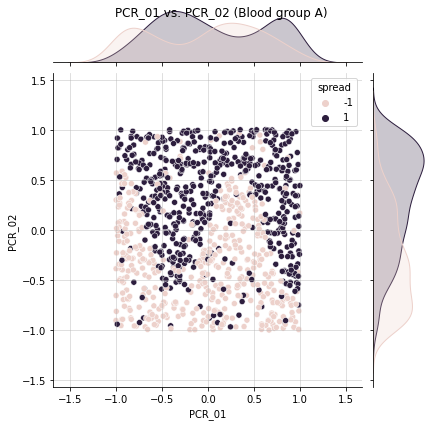

In [ ]:
g = sns.jointplot(x='PCR_01', y='PCR_02', data=prep_train, color='blue', hue='spread')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("PCR_01 vs. PCR_02 (Blood group A)")

#### Q2:  kNN (k=1) PCR_01, PCR_02:

In [ ]:
def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()
   

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


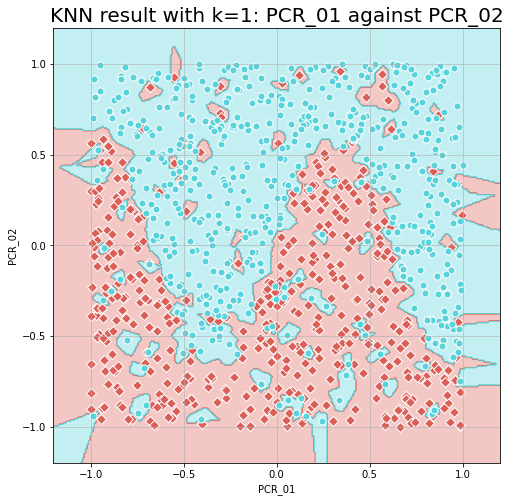

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_df_x = prep_train[["PCR_01", "PCR_02"]]
knn_df_y = np.array(prep_train.spread)

knn = KNeighborsClassifier(n_neighbors=1)


knn.fit(knn_df_x, knn_df_y)

visualize_clf(knn, knn_df_x, knn_df_y, "KNN result with k=1: PCR_01 against PCR_02", "PCR_01", "PCR_02")

## Model selection

#### Q3:  Finding the optimal K for our problem (hyperparameter tuning):

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

rng = list(range(1, 20, 2)) + list(range(20, 871, 85))
train_list, test_list = [], []

for k in rng:
  knn = KNeighborsClassifier(n_neighbors=k)
  cv = cross_validate(estimator=knn, X=knn_df_x, y=knn_df_y, cv=8, return_train_score=True)
  train_list.append(cv['train_score'].mean())
  test_list.append(cv['test_score'].mean())

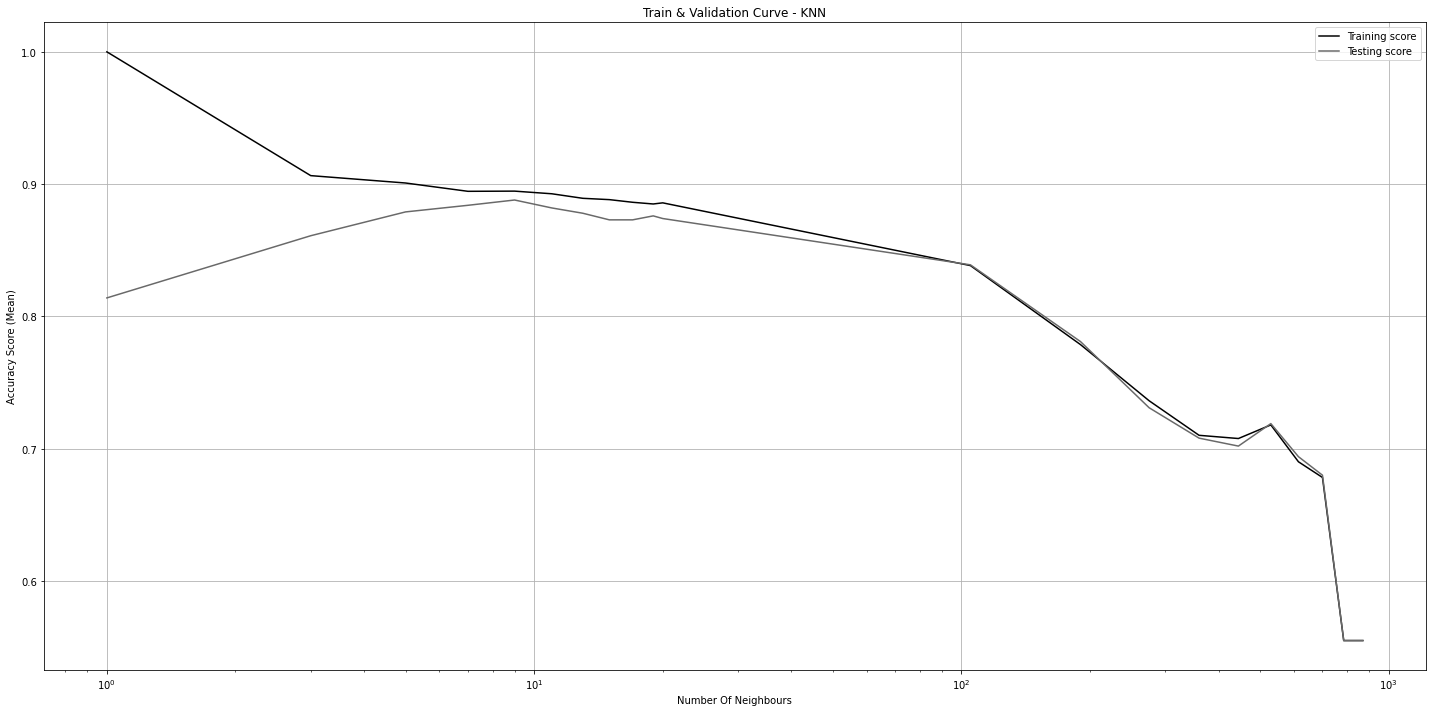

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(rng, train_list, label="Training score", color="black")
plt.plot(rng, test_list, label="Testing score", color="dimgrey")
plt.semilogx()
plt.title("Train & Validation Curve - KNN")
plt.xlabel("Number Of Neighbours")
plt.ylabel("Accuracy Score (Mean)")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

Best K and its mean training and validation accuracies:

In [ ]:
print(f"Best k: {rng[np.argmax(test_list)]}")
print(f"Best k mean train accuracy: {train_list[np.argmax(test_list)]}")
print(f"Best k mean test/validation accuracy: {test_list[np.argmax(test_list)]}")

Best k: 9
Best k mean train accuracy: 0.8947142857142858
Best k mean test/validation accuracy: 0.888


#### Q4:  Using the optimal K we found:

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


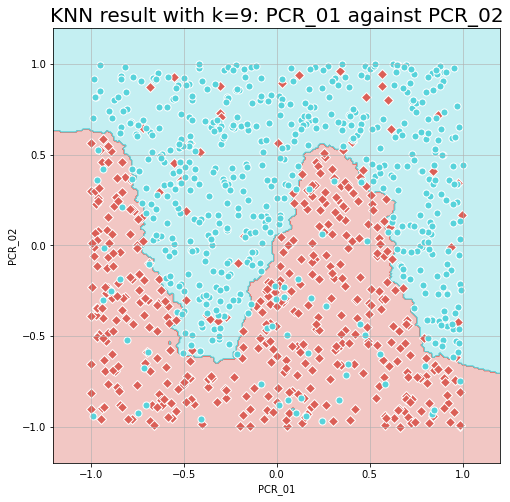

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_df_x = prep_train[["PCR_01", "PCR_02"]]
knn_df_y = np.array(prep_train.spread)

knn = KNeighborsClassifier(n_neighbors=9)


knn.fit(knn_df_x, knn_df_y)

visualize_clf(knn, knn_df_x, knn_df_y, "KNN result with k=9: PCR_01 against PCR_02", "PCR_01", "PCR_02")

Testing the model (k=9):

In [ ]:
knn_df_x = prep_test[["PCR_01", "PCR_02"]]
knn_df_y = np.array(prep_test.spread)

print(f"kNN (k=9) test accuracy: {knn.score(knn_df_x, knn_df_y)}")

kNN (k=9) test accuracy: 0.84


#### Q5:  kNN with k=1, k=501:

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


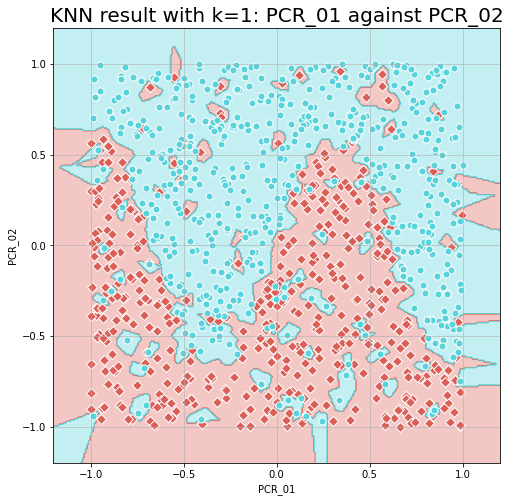

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_df_x = prep_train[["PCR_01", "PCR_02"]]
knn_df_y = np.array(prep_train.spread)

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(knn_df_x, knn_df_y)

visualize_clf(knn, knn_df_x, knn_df_y, "KNN result with k=1: PCR_01 against PCR_02", "PCR_01", "PCR_02")

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


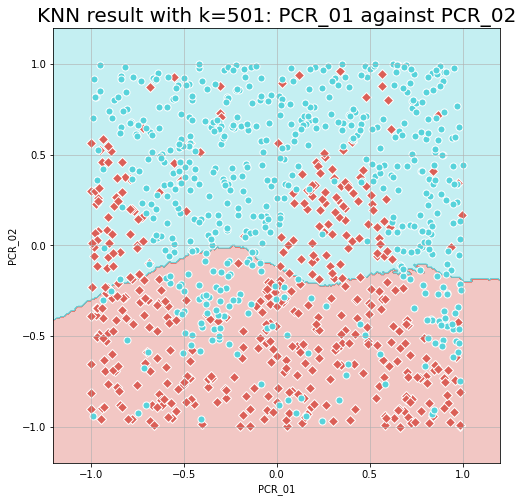

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_df_x = prep_train[["PCR_01", "PCR_02"]]
knn_df_y = np.array(prep_train.spread)

knn = KNeighborsClassifier(n_neighbors=501)

knn.fit(knn_df_x, knn_df_y)

visualize_clf(knn, knn_df_x, knn_df_y, "KNN result with k=501: PCR_01 against PCR_02", "PCR_01", "PCR_02")

#### Q6:  kNN with all of the features:

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

knn_df_x = prep_train.copy()
knn_df_x.drop('spread', inplace=True ,axis=1)
knn_df_x.drop('risk', inplace=True ,axis=1)
knn_df_y = np.array(prep_train.spread)

rng = list(range(1, 20, 2)) + list(range(20, 871, 85))
train_list, test_list = [], []

for k in rng:
  knn = KNeighborsClassifier(n_neighbors=k)
  cv = cross_validate(estimator=knn, X=knn_df_x, y=knn_df_y, cv=8, return_train_score=True)
  train_list.append(cv['train_score'].mean())
  test_list.append(cv['test_score'].mean())

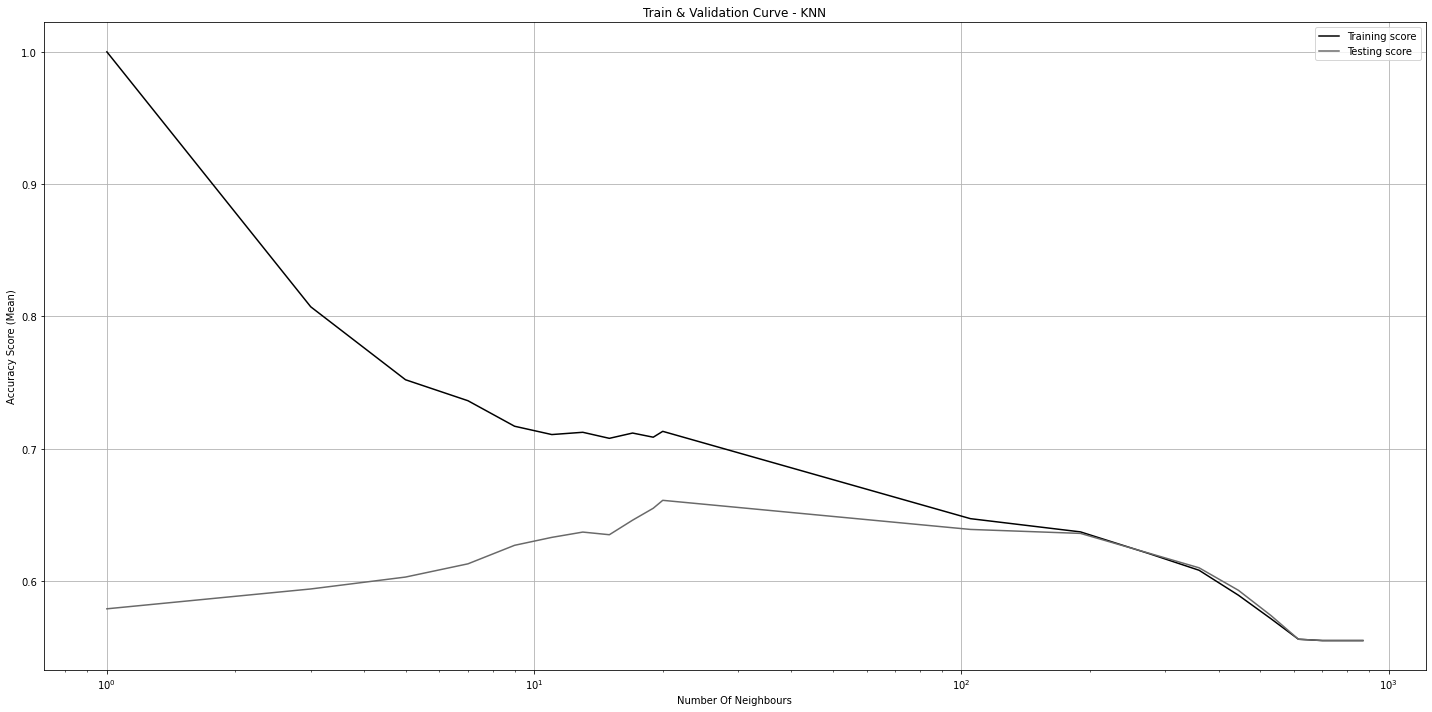

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(rng, train_list, label="Training score", color="black")
plt.plot(rng, test_list, label="Testing score", color="dimgrey")
plt.semilogx()
plt.title("Train & Validation Curve - KNN")
plt.xlabel("Number Of Neighbours")
plt.ylabel("Accuracy Score (Mean)")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

In [ ]:
print(f"Best k: {rng[np.argmax(test_list)]}")
print(f"Best k mean train accuracy: {train_list[np.argmax(test_list)]}")
print(f"Best k mean test/validation accuracy: {test_list[np.argmax(test_list)]}")

Best k: 20
Best k mean train accuracy: 0.7131428571428571
Best k mean test/validation accuracy: 0.6609999999999999


# Part 2: Decision trees


## Visualization

#### Q7:  DT with all max depth of 4:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_df_x = prep_train.copy()
dt_df_x.drop('spread', inplace=True ,axis=1)
dt_df_x.drop('risk', inplace=True ,axis=1)
dt_df_y = np.array(prep_train.risk)

h = DecisionTreeClassifier(criterion="entropy", max_depth=4)
print(h.fit(dt_df_x, dt_df_y))

trainAcc = np.sum(h.predict(dt_df_x) == dt_df_y) * 100 / len(dt_df_y)

print("Train Accuracy: {:.1f}%".format(trainAcc))

DecisionTreeClassifier(criterion='entropy', max_depth=4)
Train Accuracy: 80.0%


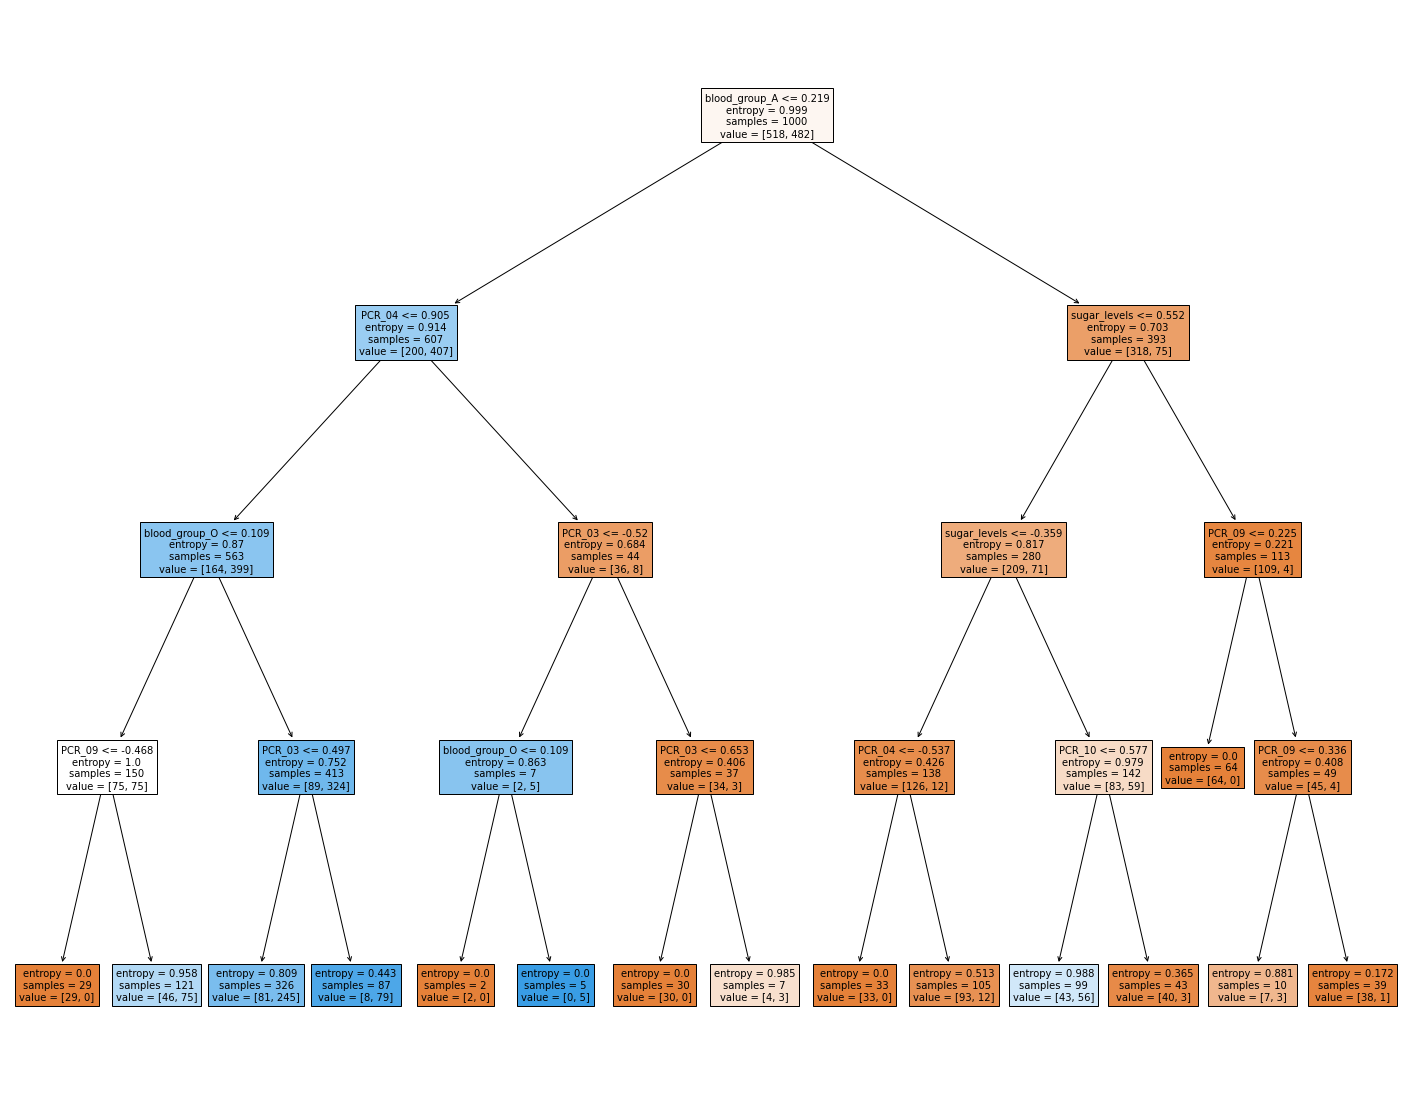

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
_ = plot_tree(h, filled=True, feature_names=list(dt_df_x.columns.values), fontsize=10)

## Model selection

#### Q8:  DT hyperparameters (max_depth, min_samples_leaf):

best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=19)


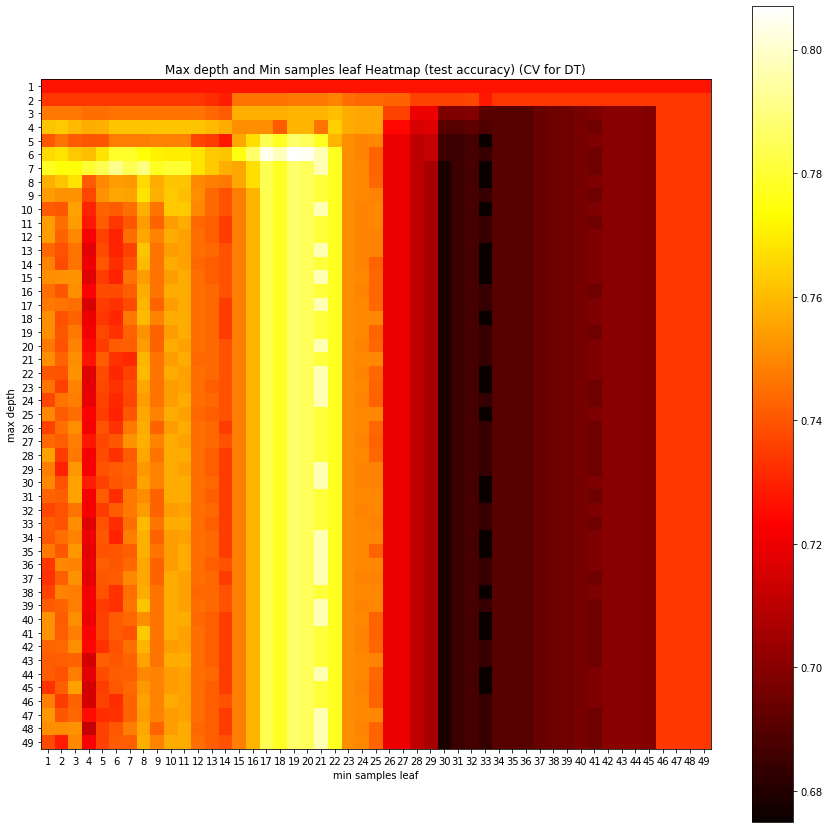

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

md_range = list(range(1, 50))
msl_range = list(range(1, 50))
parameters = {'max_depth':md_range, 'min_samples_leaf':msl_range}

dt_df_x = prep_train.copy()
dt_df_x.drop('spread', inplace=True ,axis=1)
dt_df_x.drop('risk', inplace=True ,axis=1)
dt_df_y = np.array(prep_train.risk)

h = DecisionTreeClassifier(criterion="entropy", max_depth=4)
clf = GridSearchCV(h, parameters, cv=2, return_train_score=True)
clf.fit(dt_df_x, dt_df_y)
print(f"best estimator: {clf.best_estimator_}")

scores = clf.cv_results_['mean_test_score'].reshape(len(md_range),len(msl_range))
plt.figure(figsize=(15, 15))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('min samples leaf')
plt.ylabel('max depth')
plt.colorbar()
plt.xticks(np.arange(len(msl_range)), msl_range)
plt.yticks(np.arange(len(md_range)), md_range)
plt.title('Max depth and Min samples leaf Heatmap (test accuracy) (CV for DT)')
plt.show()

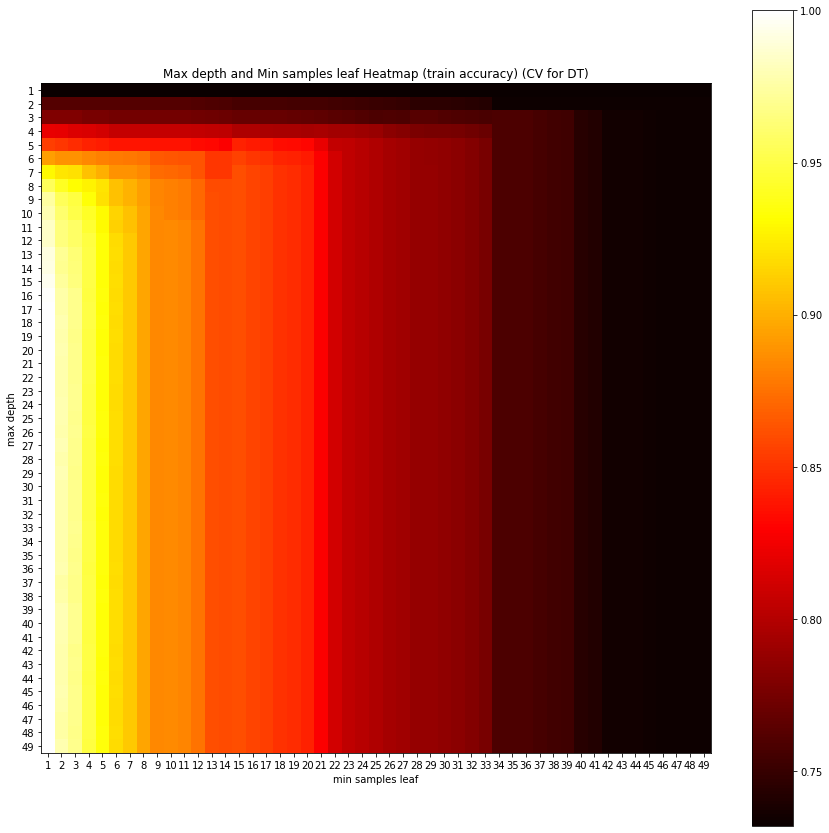

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(len(md_range),len(msl_range))
plt.figure(figsize=(15, 15))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('min samples leaf')
plt.ylabel('max depth')
plt.colorbar()
plt.xticks(np.arange(len(msl_range)), msl_range)
plt.yticks(np.arange(len(md_range)), md_range)
plt.title('Max depth and Min samples leaf Heatmap (train accuracy) (CV for DT)')
plt.show()

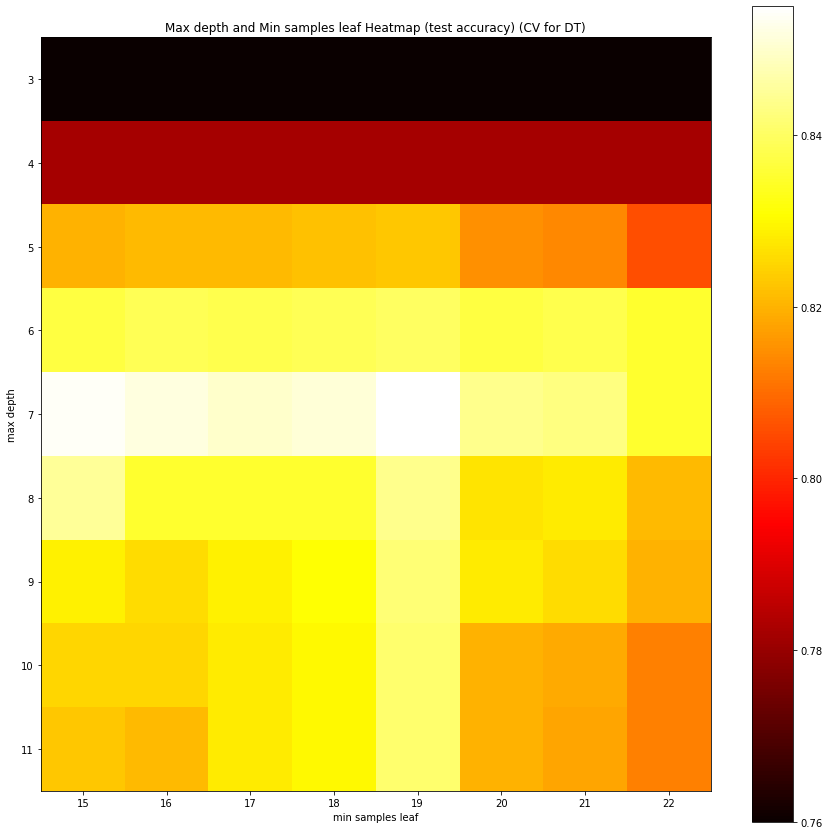

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

md_range = list(range(3, 12))
msl_range = list(range(15, 23))
parameters = {'max_depth':md_range, 'min_samples_leaf':msl_range}

dt_df_x = prep_train.copy()
dt_df_x.drop('spread', inplace=True ,axis=1)
dt_df_x.drop('risk', inplace=True ,axis=1)
dt_df_y = np.array(prep_train.risk)

h = DecisionTreeClassifier(criterion="entropy", max_depth=4)
clf = GridSearchCV(h, parameters, cv=8, return_train_score=True)
clf.fit(dt_df_x, dt_df_y)

scores = clf.cv_results_['mean_test_score'].reshape(len(md_range),len(msl_range))
plt.figure(figsize=(15, 15))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('min samples leaf')
plt.ylabel('max depth')
plt.colorbar()
plt.xticks(np.arange(len(msl_range)), msl_range)
plt.yticks(np.arange(len(md_range)), md_range)
plt.title('Max depth and Min samples leaf Heatmap (test accuracy) (CV for DT)')
plt.show()

best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=19)


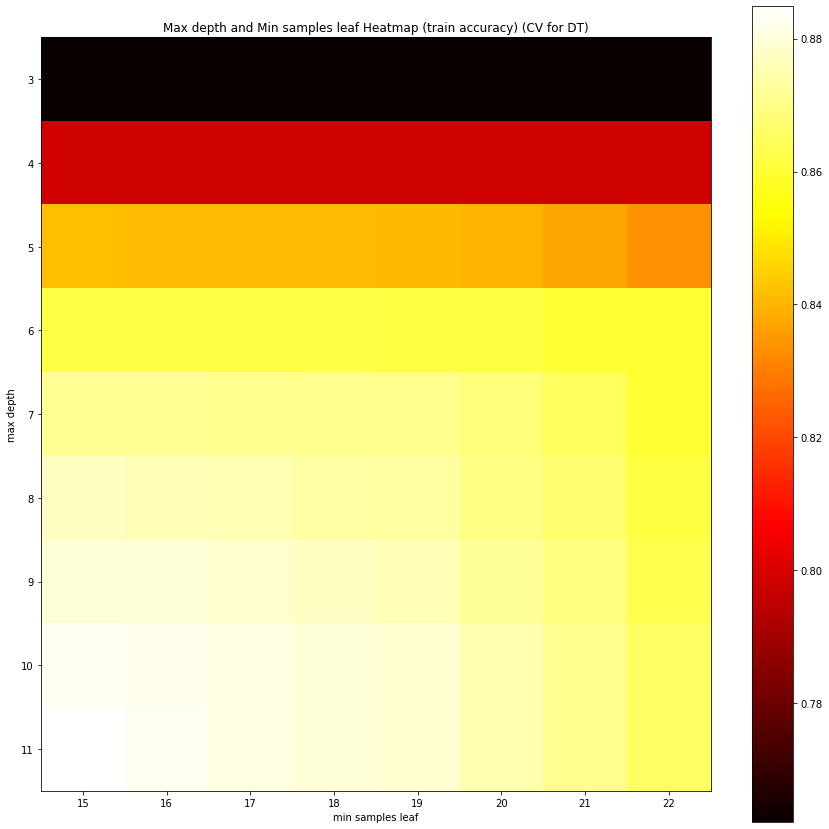

In [ ]:
print(f"best estimator: {clf.best_estimator_}")

scores = clf.cv_results_['mean_train_score'].reshape(len(md_range),len(msl_range))
plt.figure(figsize=(15, 15))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('min samples leaf')
plt.ylabel('max depth')
plt.colorbar()
plt.xticks(np.arange(len(msl_range)), msl_range)
plt.yticks(np.arange(len(md_range)), md_range)
plt.title('Max depth and Min samples leaf Heatmap (train accuracy) (CV for DT)')
plt.show()

#### Q9:  DT with the optimal hyperparameters:

In [ ]:
dt_df_x = prep_train.copy()
dt_df_x.drop('spread', inplace=True ,axis=1)
dt_df_x.drop('risk', inplace=True ,axis=1)
dt_df_y = np.array(prep_train.risk)

dt_df_test_x = prep_test.copy()
dt_df_test_x.drop('spread', inplace=True ,axis=1)
dt_df_test_x.drop('risk', inplace=True ,axis=1)
dt_df_test_y = np.array(prep_test.risk)

h = DecisionTreeClassifier(criterion="entropy", max_depth=7, min_samples_leaf=19)
print(h.fit(dt_df_x, dt_df_y))

trainAcc = np.sum(h.predict(dt_df_x) == dt_df_y) * 100 / len(dt_df_y)
print("Train Accuracy: {:.1f}%".format(trainAcc))

testAcc = np.sum(h.predict(dt_df_test_x) == dt_df_test_y) * 100 / len(dt_df_test_y)
print("Test Accuracy: {:.1f}%".format(testAcc))

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=19)
Train Accuracy: 86.7%
Test Accuracy: 84.0%


# Part 3: Linear SVM and the Polynomial kernel

## Implementation of the loss and its gradient

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
        loss = np.maximum(0, 1 - hinge_inputs)
        loss_sum = C * np.sum(loss)
        norm_squard = np.power(np.linalg.norm(w), 2)

        return norm_squard + loss_sum

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        f_val = np.where(hinge_inputs < 1, -1, 0)
        f_val_y = np.multiply(f_val, y.reshape(-1, 1))
        f_val_yx = X.T.dot(f_val_y).reshape(-1)

        g_w = np.add(np.multiply(2, w), np.multiply(C, f_val_yx))
        g_b = C * np.sum(f_val_y)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]
        
        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            self.w = self.w - (self.lr * g_w)
            self.b = self.b - (self.lr * g_b)

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """

        return np.sign(X.dot(self.w) + self.b)

Testing our SGD:

In [ ]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b

def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)      
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


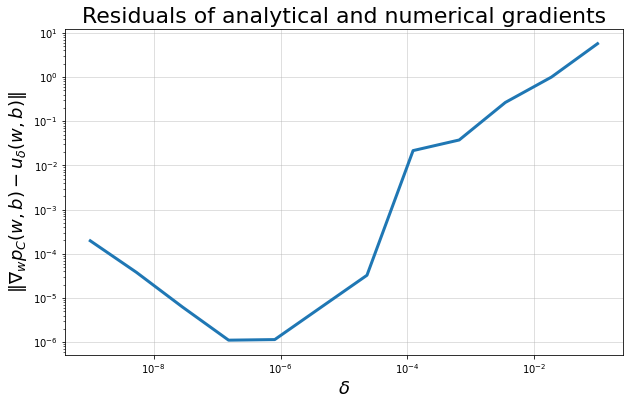

In [ ]:
X_train = prep_train[["PCR_01", "PCR_02"]].to_numpy()
y_train = prep_train["spread"].to_numpy()


compare_gradients(X_train, y_train, deltas=np.logspace(-9, -1, 12))

Plotting the model Accuracy and Loss with different learning rate:

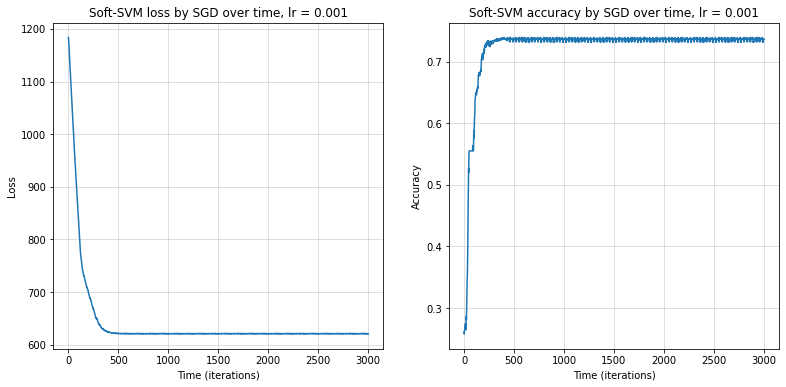

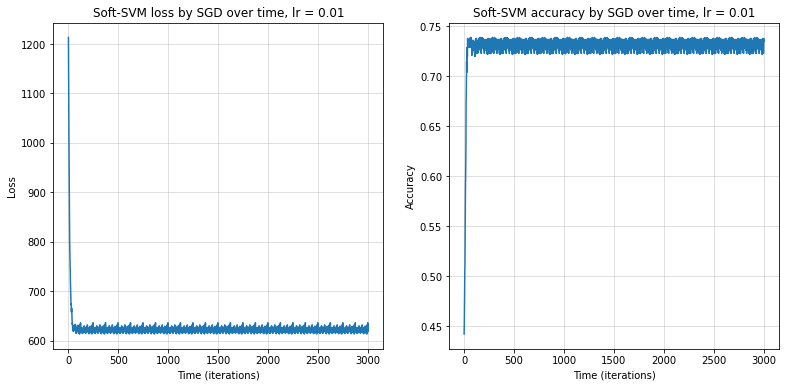

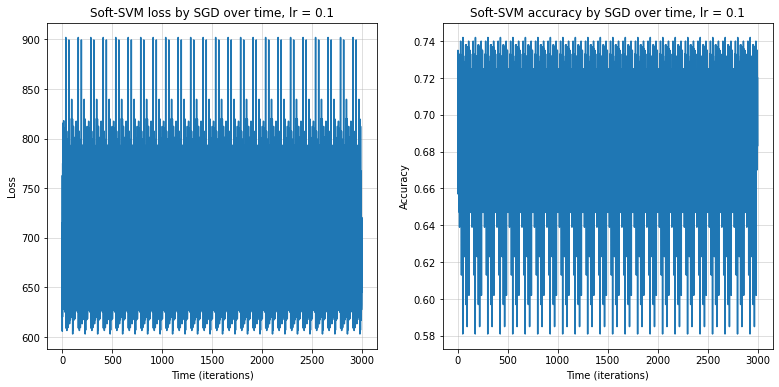

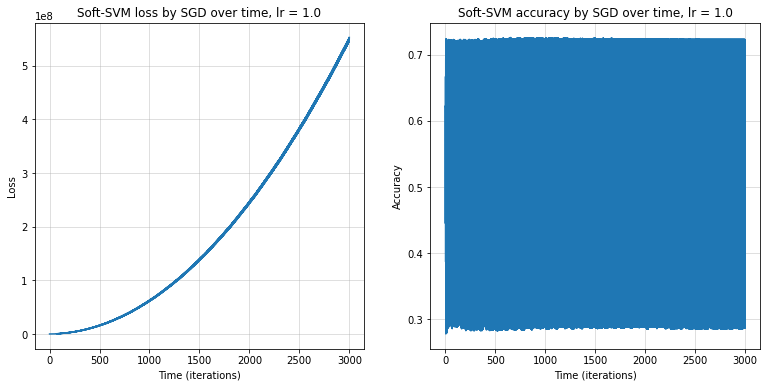

In [ ]:
for lr in np.logspace(-3, 0, 4):
  clf = SoftSVM(C=1, lr=lr, batch_size=32)
  losses, accuracies = clf.fit_with_logs(X_train, y_train, max_iter=3000)
  plt.figure(figsize=(13, 6))
  plt.subplot(121), plt.grid(alpha=0.5), plt.title (f"Soft-SVM loss by SGD over time, lr = {lr}")
  plt.plot(losses), plt.xlabel("Time (iterations)"), plt.ylabel("Loss")
  plt.subplot(122), plt.grid(alpha=0.5), plt.title (f"Soft-SVM accuracy by SGD over time, lr = {lr}")
  plt.plot(accuracies), plt.xlabel("Time (iterations)"), plt.ylabel("Accuracy")

## Using a feature mapping

2nd Degree Polynomial Transformation of the features:

2nd Degree Train Accuracy=0.74
2nd Degree Test Accuracy=0.704


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


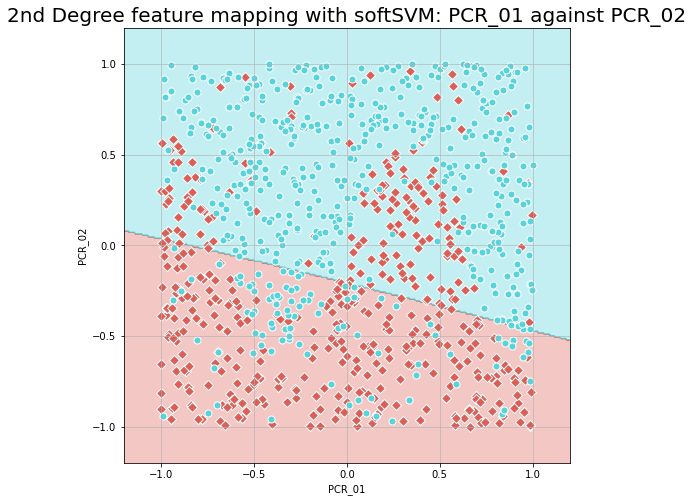

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

C=1e13
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=2)),
                    ('scaler', StandardScaler()), ('SVM', SoftSVM(C=C, lr=(1/(C*5e2))))])


X_train_svm = prep_train[["PCR_01", "PCR_02"]]
y_train_svm = np.array(prep_train.spread)
X_test_svm = prep_test[["PCR_01", "PCR_02"]]
y_test_svm = np.array(prep_test.spread)


svm_clf.fit(X_train_svm, y_train_svm, SVM__max_iter=10000)
print(f"2nd Degree Train Accuracy={svm_clf.score(X_train_svm, y_train_svm)}")
print(f"2nd Degree Test Accuracy={svm_clf.score(X_test_svm, y_test_svm)}")

visualize_clf(svm_clf, X_train_svm, y_train_svm, "2nd Degree feature mapping with softSVM: PCR_01 against PCR_02", "PCR_01", "PCR_02")

3rd Degree Polynomial Transformation of the features:

3rd Degree Train Accuracy=0.854
3rd Degree Test Accuracy=0.804


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


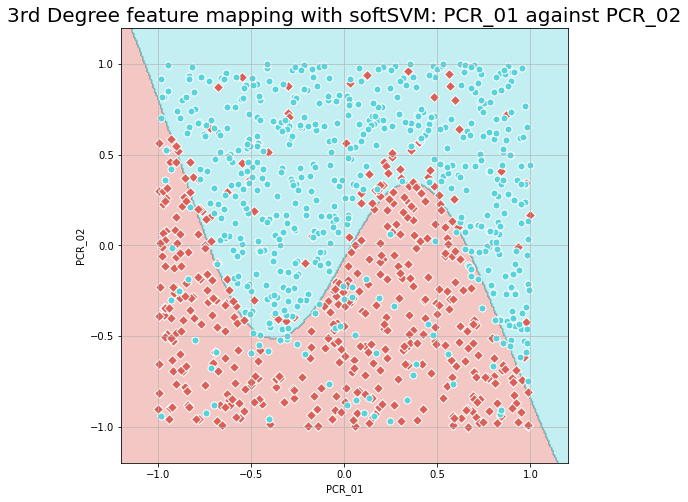

In [ ]:
C=1e13
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),
                    ('scaler', StandardScaler()), ('SVM', SoftSVM(C=C, lr=(1/(C*5e2))))])


svm_clf.fit(X_train_svm, y_train_svm, SVM__max_iter=10000)
print(f"3rd Degree Train Accuracy={svm_clf.score(X_train_svm, y_train_svm)}")
print(f"3rd Degree Test Accuracy={svm_clf.score(X_test_svm, y_test_svm)}")

visualize_clf(svm_clf, X_train_svm, y_train_svm, "3rd Degree feature mapping with softSVM: PCR_01 against PCR_02", "PCR_01", "PCR_02")

#### Q13: Running the 3rd Degree feature mapping with softSVM 5 times

Iteration=1: 3rd Degree Train Accuracy=0.851
Iteration=1: 3rd Degree Test Accuracy=0.804


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


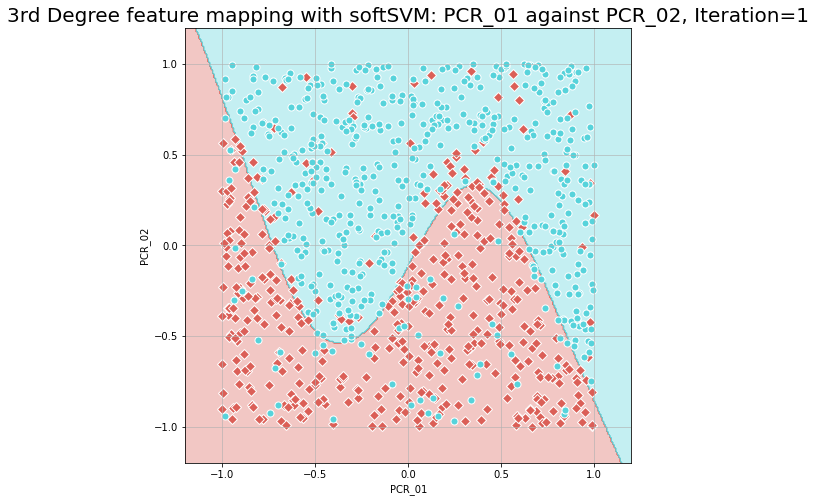

Iteration=2: 3rd Degree Train Accuracy=0.853
Iteration=2: 3rd Degree Test Accuracy=0.8


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


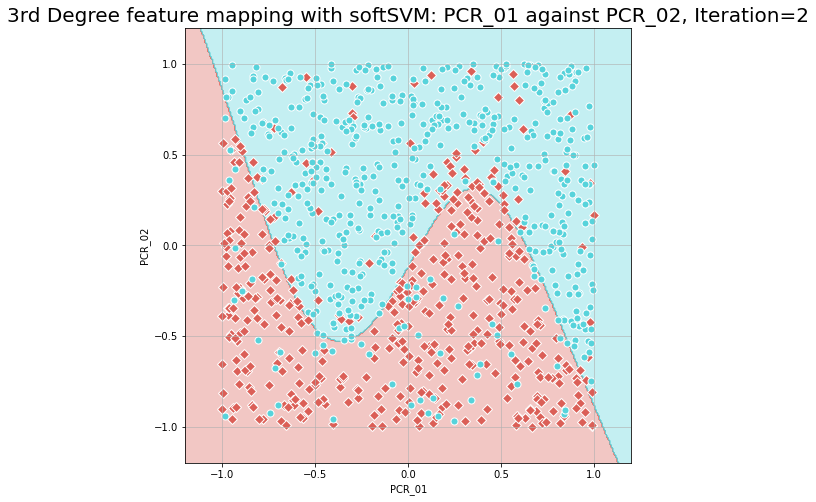

Iteration=3: 3rd Degree Train Accuracy=0.852
Iteration=3: 3rd Degree Test Accuracy=0.804


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


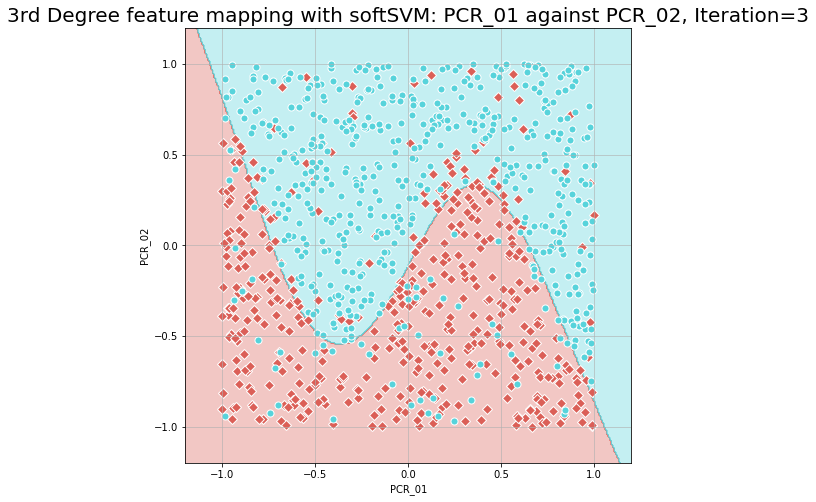

Iteration=4: 3rd Degree Train Accuracy=0.856
Iteration=4: 3rd Degree Test Accuracy=0.808


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


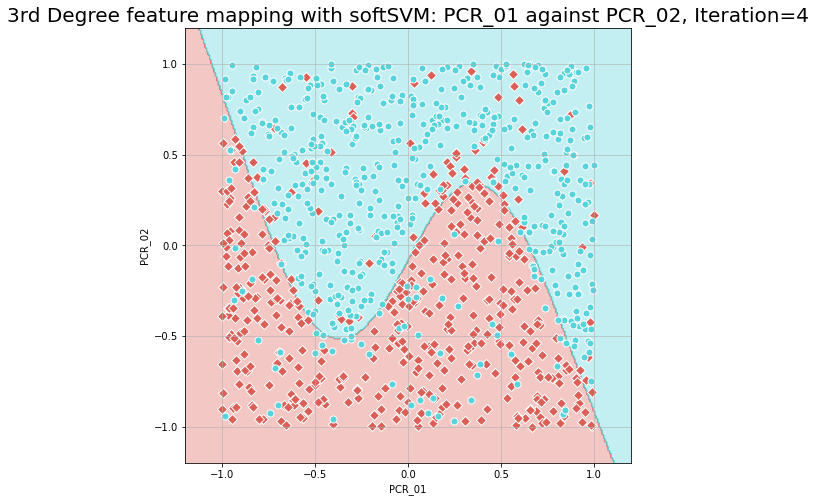

Iteration=5: 3rd Degree Train Accuracy=0.844
Iteration=5: 3rd Degree Test Accuracy=0.796


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


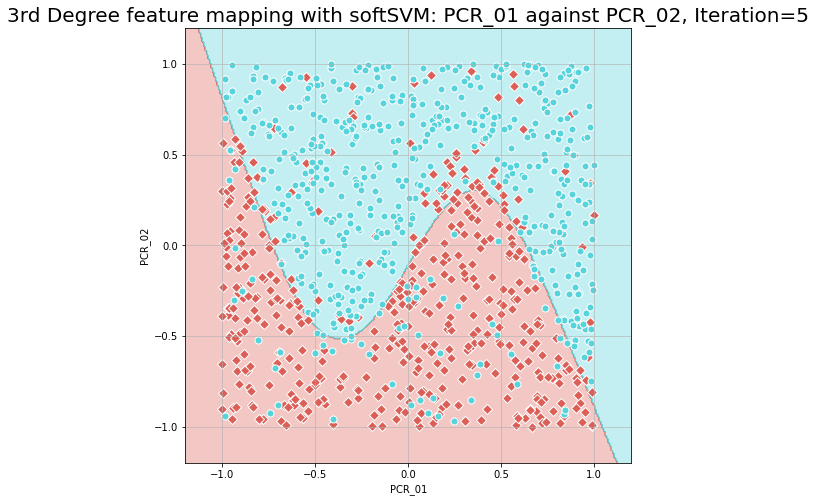

In [ ]:
C=1e13

for i in range(1,6):
  svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),
                      ('scaler', StandardScaler()), ('SVM', SoftSVM(C=C, lr=(1/(C*5e2))))])


  svm_clf.fit(X_train_svm, y_train_svm, SVM__max_iter=10000)
  print(f"Iteration={i}: 3rd Degree Train Accuracy={svm_clf.score(X_train_svm, y_train_svm)}")
  print(f"Iteration={i}: 3rd Degree Test Accuracy={svm_clf.score(X_test_svm, y_test_svm)}")

  visualize_clf(svm_clf, X_train_svm, y_train_svm, f"3rd Degree feature mapping with softSVM: PCR_01 against PCR_02, Iteration={i}", "PCR_01", "PCR_02")

#Part 4: The RBF kernel

Using The RBF kernel with PCR1 and PCR2

Gamma=1e-05, 3rd Degree Train Accuracy=0.555
Gamma=1e-05, 3rd Degree Test Accuracy=0.524


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


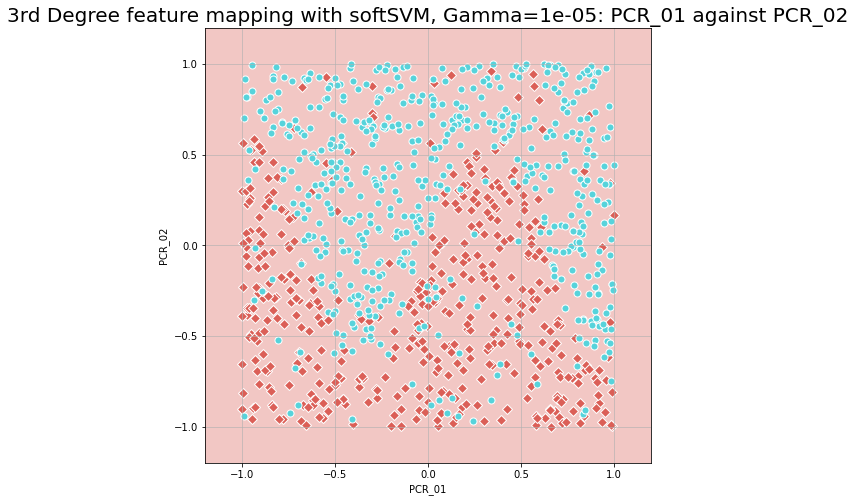

Gamma=0.0001, 3rd Degree Train Accuracy=0.555
Gamma=0.0001, 3rd Degree Test Accuracy=0.524


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


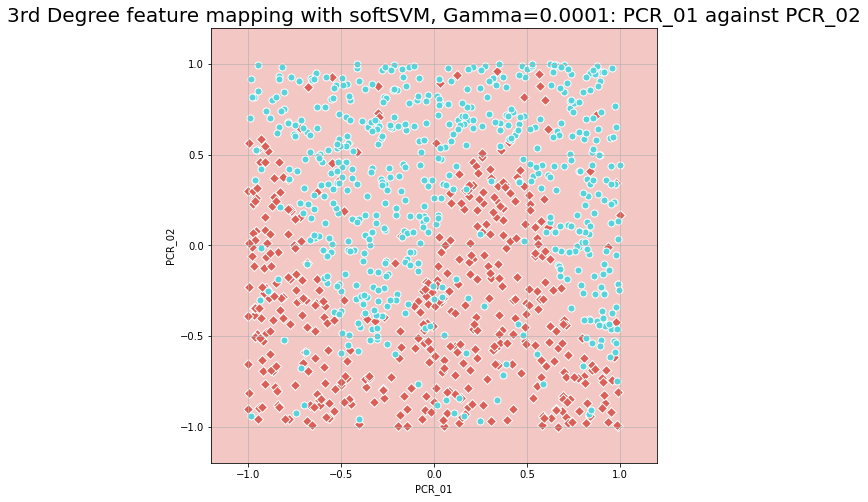

Gamma=0.001, 3rd Degree Train Accuracy=0.555
Gamma=0.001, 3rd Degree Test Accuracy=0.524


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


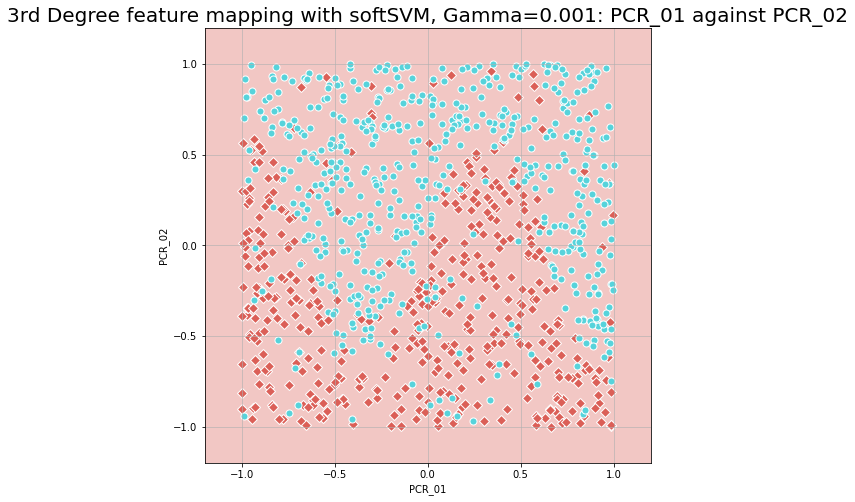

Gamma=0.01, 3rd Degree Train Accuracy=0.734
Gamma=0.01, 3rd Degree Test Accuracy=0.7


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


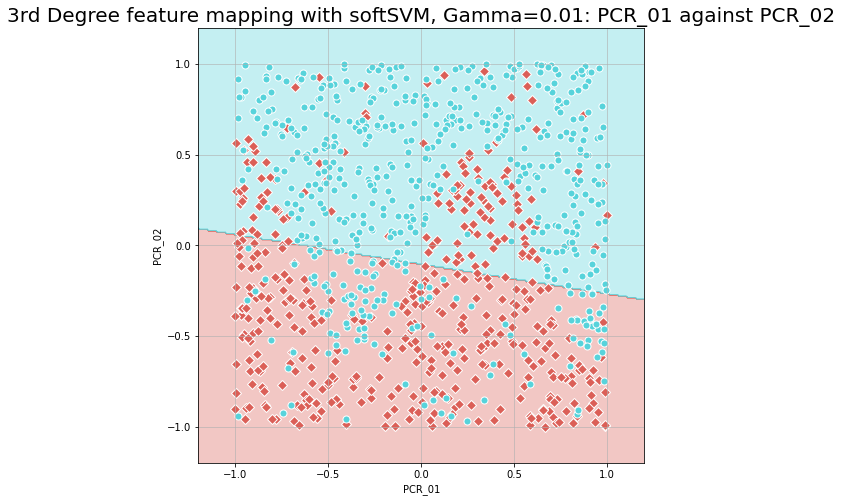

Gamma=0.1, 3rd Degree Train Accuracy=0.738
Gamma=0.1, 3rd Degree Test Accuracy=0.696


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


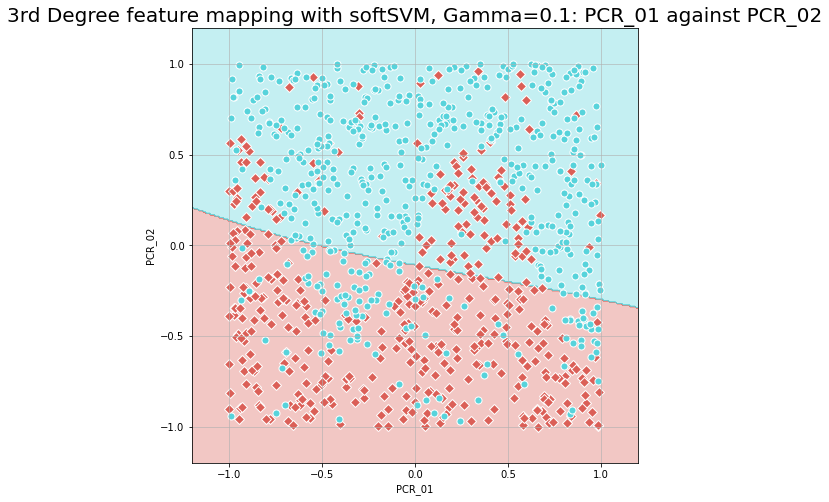

Gamma=1.0, 3rd Degree Train Accuracy=0.845
Gamma=1.0, 3rd Degree Test Accuracy=0.804


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


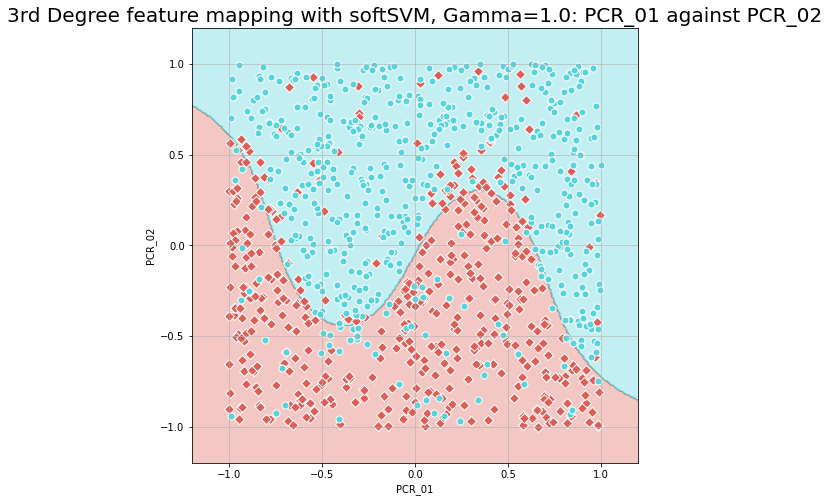

Gamma=10.0, 3rd Degree Train Accuracy=0.899
Gamma=10.0, 3rd Degree Test Accuracy=0.828


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


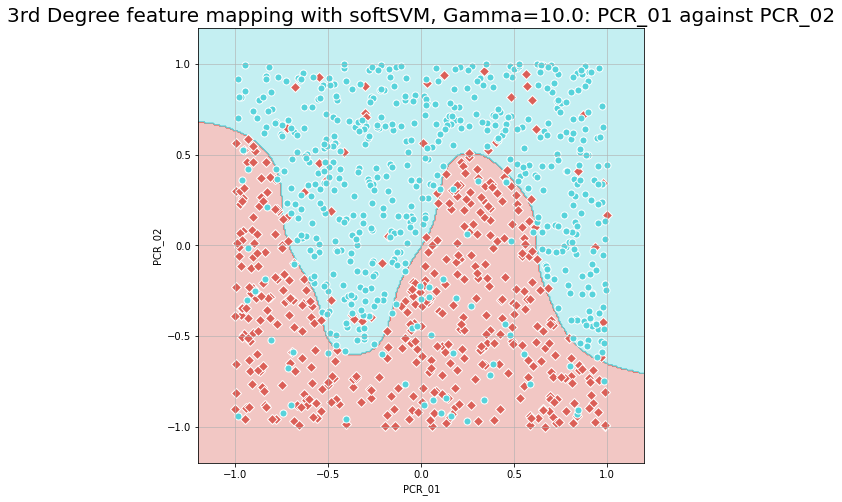

Gamma=100.0, 3rd Degree Train Accuracy=0.907
Gamma=100.0, 3rd Degree Test Accuracy=0.84


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


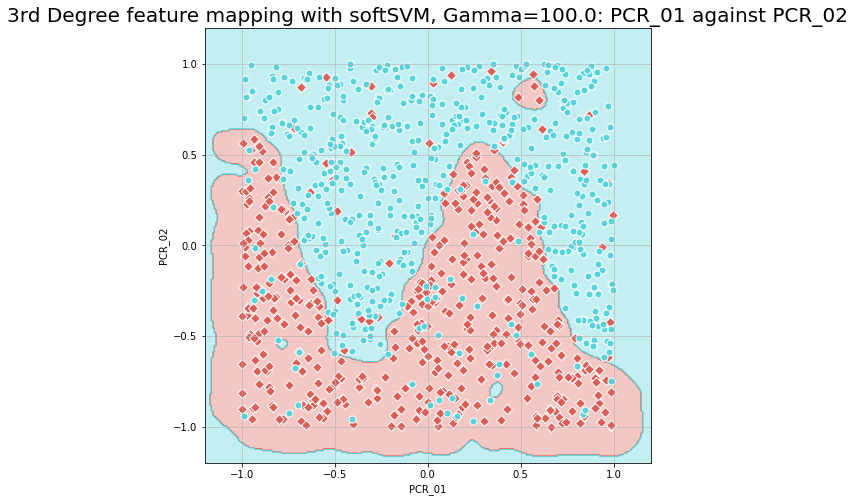

Gamma=1000.0, 3rd Degree Train Accuracy=0.982
Gamma=1000.0, 3rd Degree Test Accuracy=0.756


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


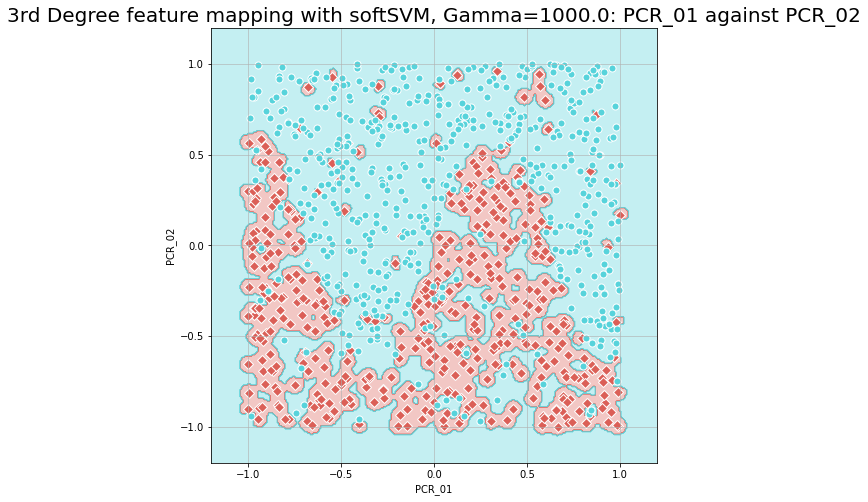

Gamma=10000.0, 3rd Degree Train Accuracy=0.996
Gamma=10000.0, 3rd Degree Test Accuracy=0.572


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


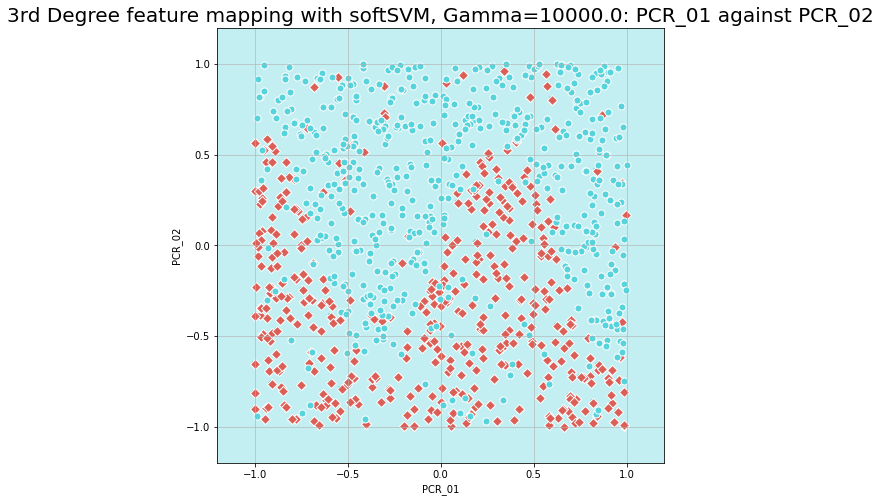

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

X_train_svm = prep_train[["PCR_01", "PCR_02"]]
y_train_svm = np.array(prep_train.spread)
X_test_svm = prep_test[["PCR_01", "PCR_02"]]
y_test_svm = np.array(prep_test.spread)

C=1e4

for gamma in np.logspace(-5, 4, 10):
  svm_clf = SVC(kernel='rbf', gamma=gamma)

  svm_clf.fit(X_train_svm, y_train_svm)
  print(f"Gamma={gamma}, 3rd Degree Train Accuracy={svm_clf.score(X_train_svm, y_train_svm)}")
  print(f"Gamma={gamma}, 3rd Degree Test Accuracy={svm_clf.score(X_test_svm, y_test_svm)}")

  visualize_clf(svm_clf, X_train_svm, y_train_svm, f"3rd Degree feature mapping with softSVM, Gamma={gamma}: PCR_01 against PCR_02", "PCR_01", "PCR_02")